# Constant Definition

In [61]:
DATASET_PATH = "./dataset/"
RANDOM_SEED = 5508

# Dataset Import and Preprocess
In this section, we import data and preprocess them. First, we create a filter from labels dataframe. Then, we filter row in features and labels, and make a copy of then. Finally, we convert label to binary, 1 for Sandal and 0 for Sneaker.

In [185]:
import pandas as pd


def readCSV(filename: str):
    return pd.read_csv(DATASET_PATH + filename, header=None)


origin_train_set = readCSV("FMNIST_training_set.csv")
origin_train_set_labels = readCSV("FMNIST_training_set_labels.csv")
origin_test_set = readCSV("FMNIST_test_set.csv")
origin_test_set_labels = readCSV("FMNIST_test_set_labels.csv")


def preprocess_data(features: pd.DataFrame, labels: pd.DataFrame):
    filter = labels.iloc[:, 0].isin([5, 7])
    filtered_features = features[filter].copy()
    filtered_labels = labels[filter].copy()
    filtered_labels[filtered_labels == 5] = 1 # Sandal
    filtered_labels[filtered_labels == 7] = 0 # Sneaker
    return filtered_features, filtered_labels


train_X, train_y = preprocess_data(origin_train_set, origin_train_set_labels)
test_X, test_y = preprocess_data(origin_test_set, origin_test_set_labels)
# check first 5 rows of the training set
train_y_copy = train_y.copy().rename(columns={0: "label"})
pd.concat([train_y_copy, train_X ], axis=1).iloc[:5,:25]

,label,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
12,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,53,102,144,169,149
41,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [218]:
origin_train_set_labels .iloc[8]

0    1
Name: 8, dtype: int64

# Summarising the datasets
## D1 [3 marks]: List number of instances
We use shape attribute to get the number of instances in the dataset. The shape attribute shows the number of rows and columns, which the first number is the number of rows.

In [189]:
pd.DataFrame(
    {
        "Number of instances": [
            train_X.shape[0],
            test_X.shape[0],
            train_X.shape[0] + test_X.shape[0],
        ]
    },
    index=["Train set", "Test set", "Total"],
)

,Number of instances
Train set,11988
Test set,2000
Total,13988


## D2 [2 marks]: Provide a bar plot showing the number of instances for each class label. Do you have an imbalanced training set?

We can see from the plot that, the numbers of two classed are balanced. So, we don't have an imbalanced training set.

<Axes: title={'center': 'Number of instances for eash class'}, xlabel='Categories'>

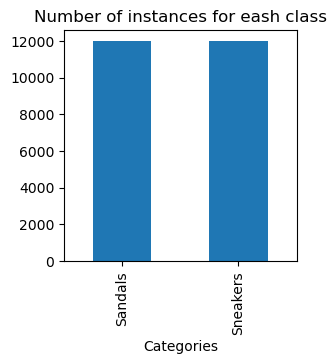

In [193]:
pd.DataFrame(
    {
        "Categories": ["Sandals", "Sneakers"],
        "Number": [
            train_y[train_y == 1].shape[0],
            train_y[train_y == 0].shape[0],
        ],
    }
).plot(
    x="Categories",
    y="Number",
    kind="bar",
    legend=False,
    title="Number of instances for eash class",
    figsize=(3, 3),
)

## D3 [3 marks]: Plot the first six images/examples from each class with the corresponding example id and associated label on the top of the plot.
First, we find the first six images of each class. Then we arrange the images so they can show in either left side or right side. Finally, we plot the images, where 1 is Sandal and 0 is Sneaker.


In [230]:
IMAGE_SHAPE = (28, 28)

sandals = []
for index, row in train_X[train_y.iloc[:, 0] == 1].iloc[:6].iterrows():
    sandals.append(
        {
            "index": index,
            "image": row.values.reshape(IMAGE_SHAPE),
            "label": 1,
        }
    )

sneakers = []
for index, row in train_X[train_y.iloc[:, 0] == 0].iloc[:6].iterrows():
    sneakers.append(
        {
            "index": index,
            "image": row.values.reshape(IMAGE_SHAPE),
            "label": 0,
        }
    )

images = []
for i in range(0, 12):
    if i % 4 < 2:
        images.append(sandals.pop(0))
    else:
        images.append(sneakers.pop(0))

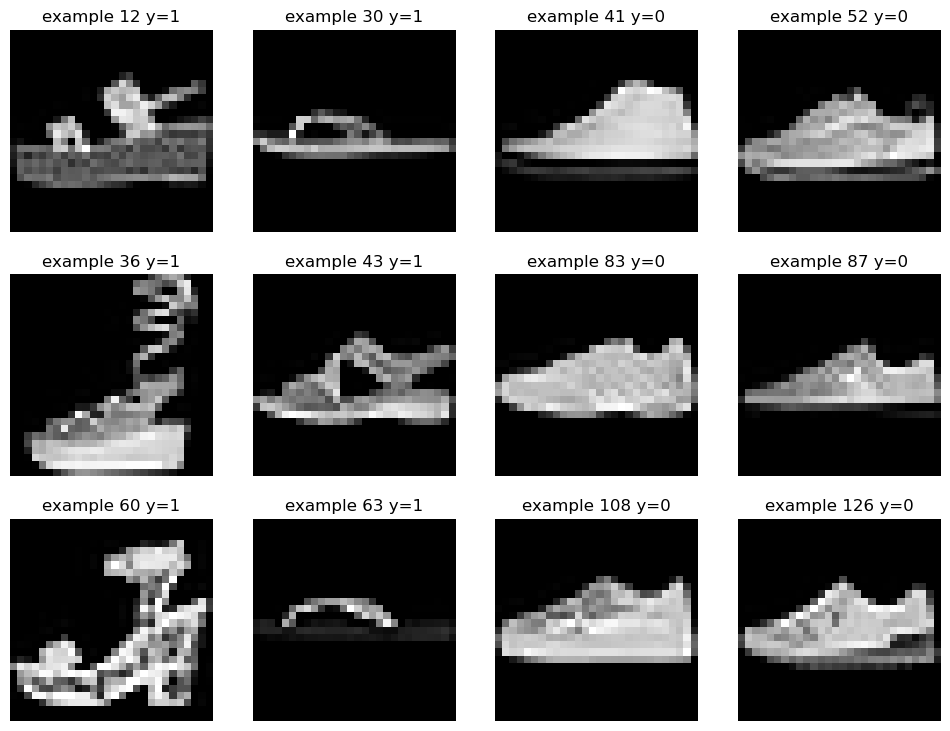

In [231]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))

axes = axes.flatten()

for i, image in enumerate(images):
    ax = axes[i]
    ax.imshow(image['image'], cmap='gray') 
    ax.set_title(f'example {image['index']} y={image['label']}')
    ax.axis('off')  # Turn off axis labels
 

# Fitting your logistic regression classifier

In [233]:
import numpy as np


train_X_b = np.c_[train_X, np.ones((train_X.shape[0], 1))]
theta = np.zeros((train_X_b.shape[1], 1))

In [234]:
train_X_b @ theta

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])